# Grid world path optimization using genetic algorithms

## Importing modules

In [1]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Video

import functions as fn

## Parameters

In [2]:
# Grid parameters
GRID_SIZE = (10, 15)
START_POSITION = (6, 1)
END_POSITION = (4, 13)
OBSTACLES = [
    (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14),
    (1, 0), (1, 14), (2, 0), (2, 5), (2, 6), (2, 11), (2, 14), (3, 0), (3, 11), (3, 14), (4, 0), (4, 9), (4, 10), (4, 11), (4, 14), 
    (5, 0), (5, 6), (5, 11), (5, 14), (6, 0), (6, 6), (6, 9), (6, 11), (6, 14), (7, 0), (7, 6), (7, 14), (8, 0), (8, 3), (8, 6), (8, 14), 
    (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14)
]
TRAPS = [(1, 3), (2, 3), (2, 7), (3, 3), (3, 10), (4, 3), (5, 3), (5, 13), (7, 9)]
NUM_OPTIMAL_STEPS = 20

# Simulation parameters
CHROMOSOME_LENGTH = 64
POPULATION_SIZE = 1000
NUM_GENERATIONS = 1000
PENALTY_COEFFICIENTS = [1, 1, 1]
BIAS = 3
PROGRESSIVE_MUTATION = False
MUTATION_RATE = 0.01
EARLY_STOP = False
BEST_ONES_PERCENTAGE = 0.05
WORST_ONES_PERCENTAGE = 0.2

# Visualization
WINDOW_SIZE = 10

# Paths
RESULTS_PATH = "./results"
GA_RESULTS_PATH = f"{RESULTS_PATH}/GA results"
GA_VERSION_PATH = f"{GA_RESULTS_PATH}/regular mutation" if not PROGRESSIVE_MUTATION else f"{GA_RESULTS_PATH}/progressive mutation"
ALL_TO_ALL_RESULTS_PATH = f"{GA_VERSION_PATH}/all to all results"
ALL_TO_ALL_VIDEO_PATH = f"{GA_VERSION_PATH}/all_to_all_results.mp4"
ALL_TO_BEST_RESULTS_PATH = f"{GA_VERSION_PATH}/all to best results"
ALL_TO_BEST_VIDEO_PATH = f"{GA_VERSION_PATH}/all_to_best_results.mp4"
HYBRID_RESULTS_PATH = f"{GA_VERSION_PATH}/hybrid results"
HYBRID_VIDEO_PATH = f"{GA_VERSION_PATH}/hybrid_results.mp4"

# Other
RANDOM_STATE = 42
LINE = 100*'-'
DOUBLE_LINE = 100*'='
SIMULATION_STARTED = 36*'-' + " !!! SIMULATION STARTED !!! " + 36*'-'
SIMULATION_FINISHED = 36*'-' + " !!! SIMULATION FINISHED !!! " + 35*'-'

## Results directories creation

In [3]:
os.makedirs(RESULTS_PATH, exist_ok=True)
for directory in [GA_RESULTS_PATH, GA_VERSION_PATH, ALL_TO_ALL_RESULTS_PATH, ALL_TO_BEST_RESULTS_PATH, HYBRID_RESULTS_PATH]:
    fn.create_or_empty_directory(directory)

## Grid world initialization

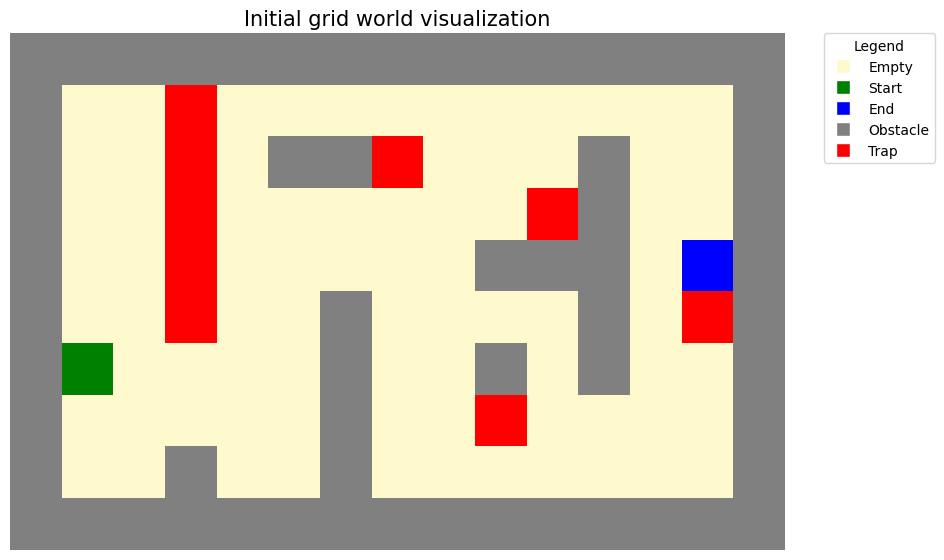

In [4]:
initial_grid_world = fn.grid_world_creation(GRID_SIZE, START_POSITION, END_POSITION, OBSTACLES, TRAPS)
fn.grid_world_visualization(initial_grid_world,title="Initial grid world visualization", agent_flag=0)

## All to all crossover case

### Simulation

In [ ]:
print(DOUBLE_LINE)
print(SIMULATION_STARTED)
print(DOUBLE_LINE)

start_time = time.time()

best_scores = []
secondary_scores_of_best = []
median_scores = []
mean_scores = []
best_grid_worlds = []
best_population_paths = []
best_generation = NUM_GENERATIONS
first_full_path_generation = 0
mutation_rate = 0
converge_flag = False

for generation in range(1, NUM_GENERATIONS+1):
    if generation == 1:
        population = [fn.generate_agent(CHROMOSOME_LENGTH, random_seed=i) for i in range(POPULATION_SIZE)]
    else:
        population = []
        for i in range(int(POPULATION_SIZE/2)):
            agent1 = fn.selection(population_sorted, bias=BIAS, mode="rank-based", random_seed=i)
            parent_flag = False
            counter = 1
            while not parent_flag:
                agent2 = fn.selection(population_sorted, bias=BIAS, mode="rank-based", random_seed=i*42+counter)
                if agent1 != agent2:
                    parent_flag = True
                else: 
                    counter += 1

            new_agent1, new_agent2 = fn.crossover(agent1, agent2, random_seed=i)

            if PROGRESSIVE_MUTATION and mutation_rate < 0.1 and fn.check_last_n_generations_same(best_scores, secondary_scores_of_best):
                mutation_rate += MUTATION_RATE
            else:
                mutation_rate = MUTATION_RATE

            mutated_new_agent1 = fn.mutate(new_agent1, mutation_probability=mutation_rate, random_seed=i)
            mutated_new_agent2 = fn.mutate(new_agent2, mutation_probability=mutation_rate, random_seed=i**2)

            population.extend([mutated_new_agent1, mutated_new_agent2])

    primary_fitness_scores = []
    secondary_fitness_scores = []
    grid_worlds = []
    population_paths = []

    for agent in population:
        primary_fitness_score, secondary_fitness_score, grid_world, path = fn.fitness_score_calculation(
            agent_path=agent, 
            grid_world=initial_grid_world, 
            chromosome_length=CHROMOSOME_LENGTH, 
            start_position=START_POSITION, 
            end_position=END_POSITION, 
            penalty_coefficients=PENALTY_COEFFICIENTS, 
            grid_size=GRID_SIZE
        )
        
        primary_fitness_scores.append(primary_fitness_score)
        secondary_fitness_scores.append(secondary_fitness_score)
        grid_worlds.append(grid_world)
        population_paths.append(path)

    population_sorted, indices_sorted = fn.population_sorting(population, primary_fitness_scores, secondary_fitness_scores)

    best_score = np.min(np.array(primary_fitness_scores))
    secondary_score_of_best = secondary_fitness_scores[indices_sorted[0]]
    median_score = round(np.median(np.array(primary_fitness_scores)),4)
    mean_score = round(np.mean(np.array(primary_fitness_scores)), 4)
    best_grid_world = grid_worlds[indices_sorted[0]]
    best_agent_path = population_paths[indices_sorted[0]]

    best_scores.append(best_score)
    secondary_scores_of_best.append(secondary_score_of_best)
    median_scores.append(median_score)
    mean_scores.append(mean_score)
    best_population_paths.append(best_agent_path)
    best_grid_worlds.append(best_grid_world)

    if generation == 1 or generation % 10 == 0:
        print(f" {generation}. generation finished - best score: {best_score} - median score: {median_score} - mean score: {mean_score} - steps: {secondary_score_of_best}")
        print(LINE)

    if best_score == 0:
        if not first_full_path_generation:
            first_full_path_generation = generation
    
        if EARLY_STOP or secondary_score_of_best == NUM_OPTIMAL_STEPS:
            converge_flag = True
            best_generation = generation
            print(f" {generation}. generation finished - best score: {best_score} - median score: {median_score} - mean score: {mean_score} - steps: {secondary_score_of_best}")
            print(LINE)
            break

_, best_indices_sorted = fn.population_sorting(best_population_paths, best_scores, secondary_scores_of_best)
best_generation = best_indices_sorted[0] + 1
final_best_score = best_scores[best_indices_sorted[0]]
final_best_secondary_score = secondary_scores_of_best[best_indices_sorted[0]]

end_time = time.time()

if not converge_flag:
    print("Optimal path is not found!")

print(f"The best generation: {best_generation}")
print(f"The best primary score: {final_best_score}")
print(f"The best secondary score: {final_best_secondary_score}")
print(f"The first full path generation: {first_full_path_generation}")

formatted_total_time, time_per_iteration, iterations_per_second = fn.create_time_report(start_time, end_time, NUM_GENERATIONS)

print(DOUBLE_LINE)
print(SIMULATION_FINISHED)
print(DOUBLE_LINE)

------------------------------------ !!! SIMULATION STARTED !!! ------------------------------------
 1. generation finished - best score: 7.0711 - median score: 13.0384 - mean score: 12.2551 - steps: 14
----------------------------------------------------------------------------------------------------
 10. generation finished - best score: 4.0 - median score: 10.0 - mean score: 9.1773 - steps: 12
----------------------------------------------------------------------------------------------------
 20. generation finished - best score: 2.2361 - median score: 7.0711 - mean score: 6.9328 - steps: 13
----------------------------------------------------------------------------------------------------
 30. generation finished - best score: 0.0 - median score: 4.0 - mean score: 4.988 - steps: 22
----------------------------------------------------------------------------------------------------
 40. generation finished - best score: 0.0 - median score: 4.0 - mean score: 4.3934 - steps: 22
--

### Result scores visualization

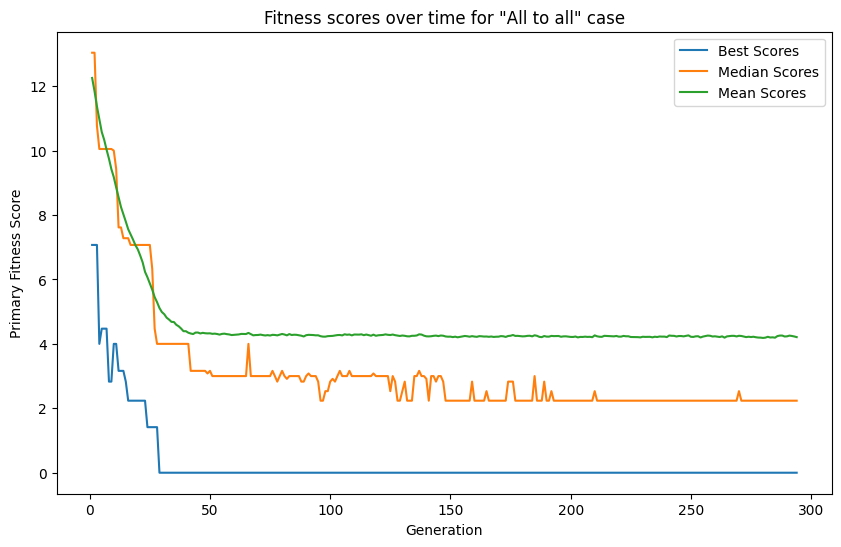

In [6]:
x_values = range(1, len(best_scores)+1)

plt.figure(figsize=(10, 6))

plt.plot(x_values, best_scores, label="Best Scores")
plt.plot(x_values, median_scores, label="Median Scores")
plt.plot(x_values, mean_scores, label="Mean Scores")

plt.title("Fitness scores over time for \"All to all\" case")
plt.xlabel("Generation")
plt.ylabel("Primary Fitness Score")
plt.legend()

plt.show()

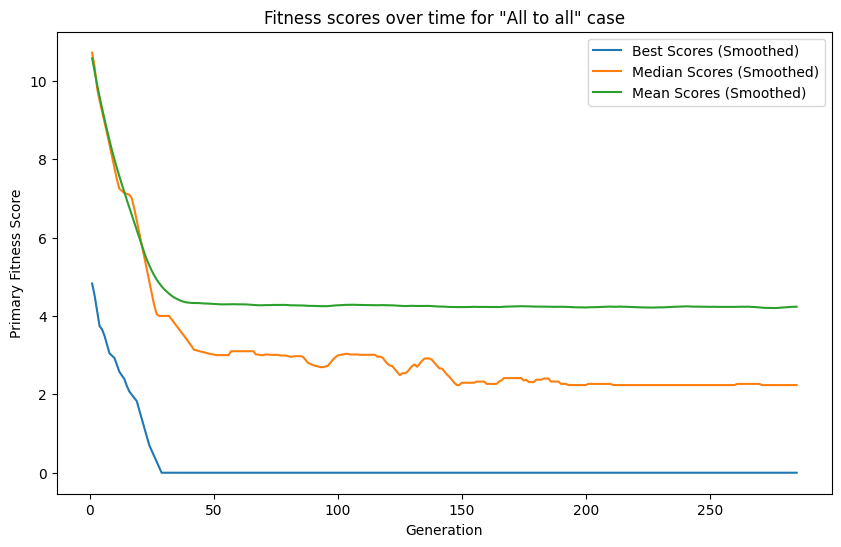

In [7]:
best_scores_smooth = fn.moving_average(best_scores, WINDOW_SIZE)
median_scores_smooth = fn.moving_average(median_scores, WINDOW_SIZE)
mean_scores_smooth = fn.moving_average(mean_scores, WINDOW_SIZE)

x_values_smooth = range(1, len(best_scores_smooth) + 1)

plt.figure(figsize=(10, 6))

plt.plot(x_values_smooth, best_scores_smooth, label="Best Scores (Smoothed)")
plt.plot(x_values_smooth, median_scores_smooth, label="Median Scores (Smoothed)")
plt.plot(x_values_smooth, mean_scores_smooth, label="Mean Scores (Smoothed)")

plt.title("Fitness scores over time for \"All to all\" case")
plt.xlabel("Generation")
plt.ylabel("Primary Fitness Score")
plt.legend()

plt.show()

### Grid world path optimization evolution

1. generation 1 grid world


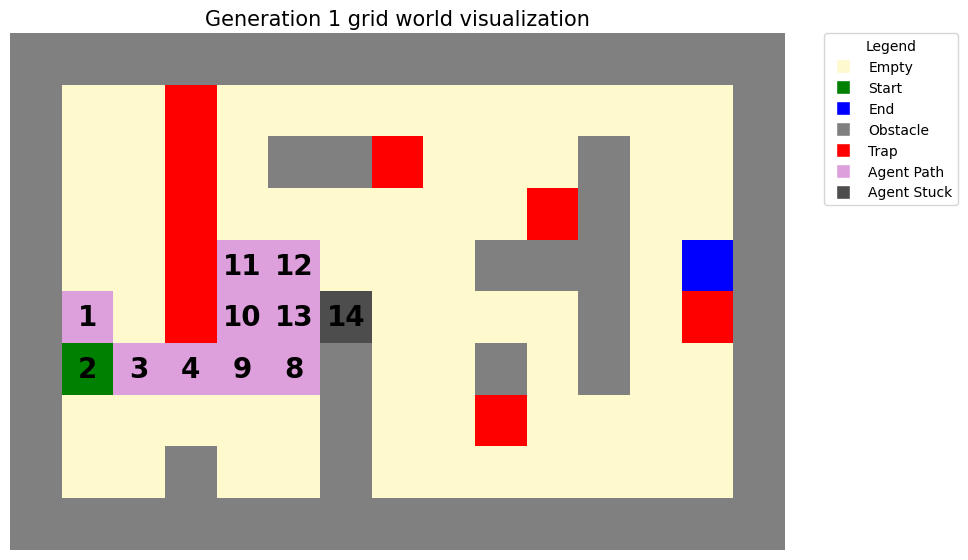

----------------------------------------------------------------------------------------------------

2. generation 29 grid world


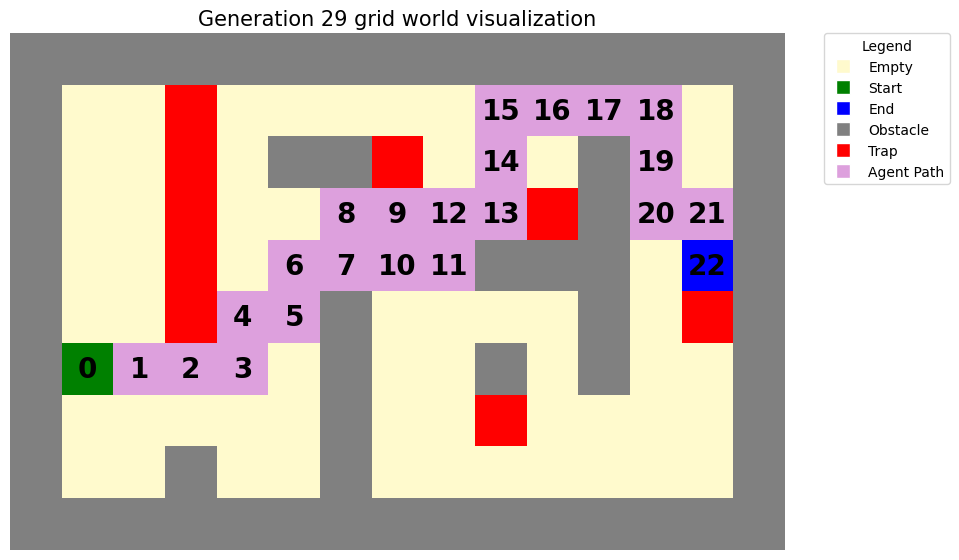

----------------------------------------------------------------------------------------------------

3. generation 58 grid world


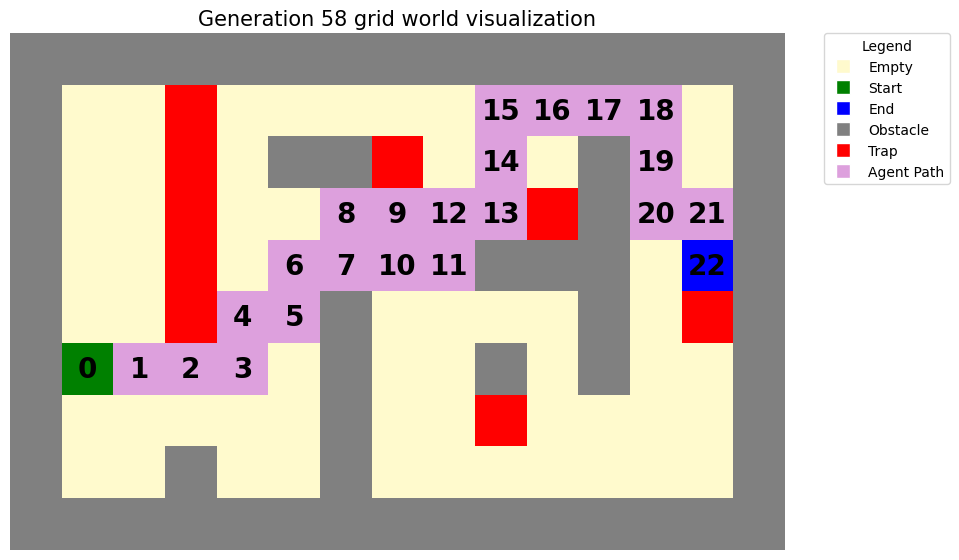

----------------------------------------------------------------------------------------------------

4. generation 87 grid world


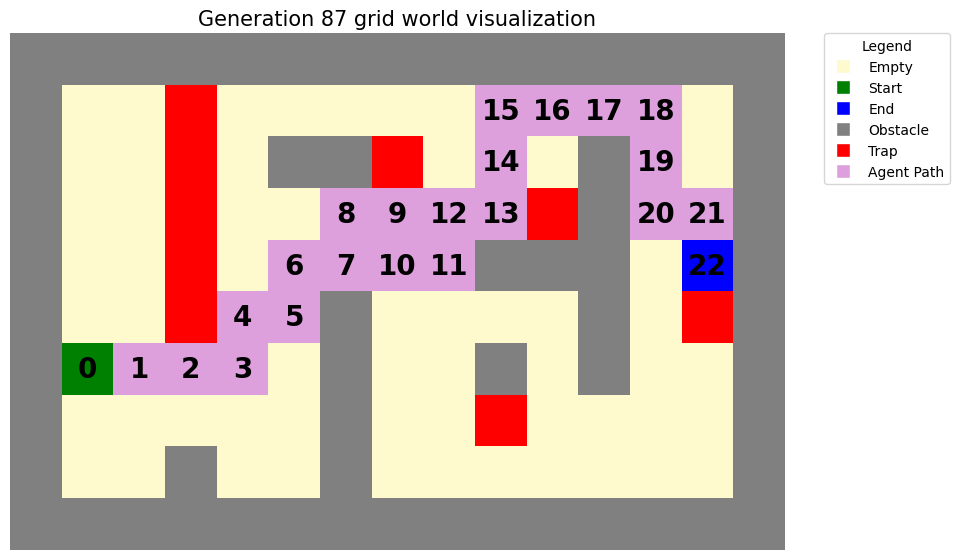

----------------------------------------------------------------------------------------------------

5. generation 116 grid world


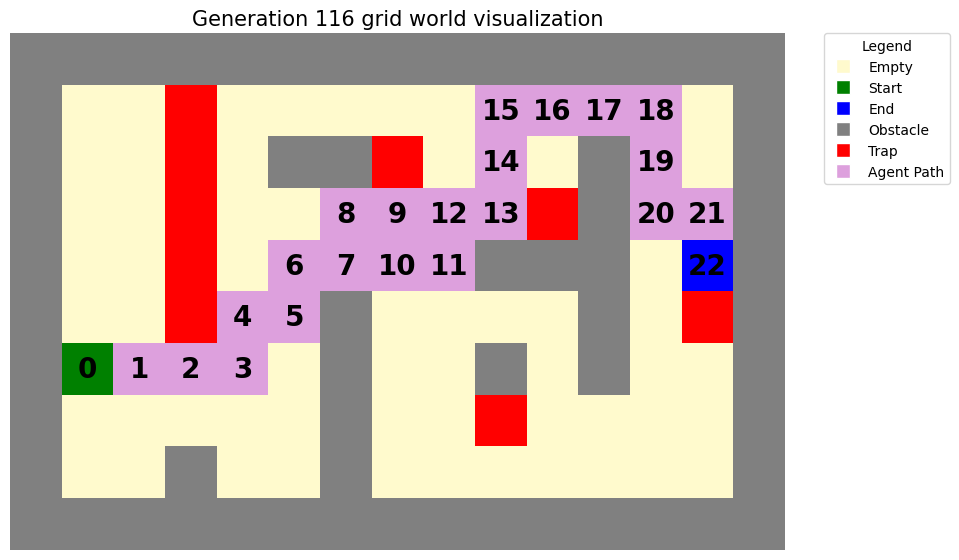

----------------------------------------------------------------------------------------------------

6. generation 145 grid world


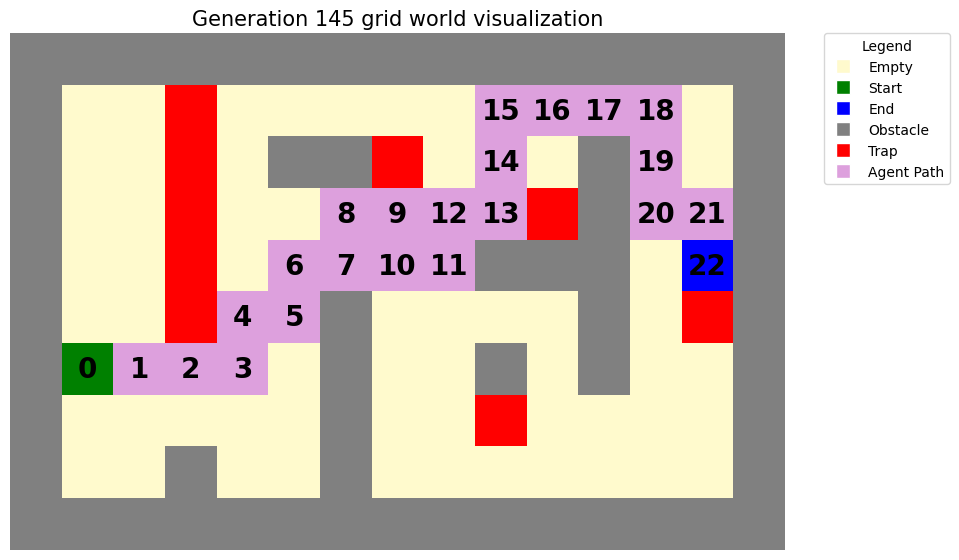

----------------------------------------------------------------------------------------------------

7. generation 174 grid world


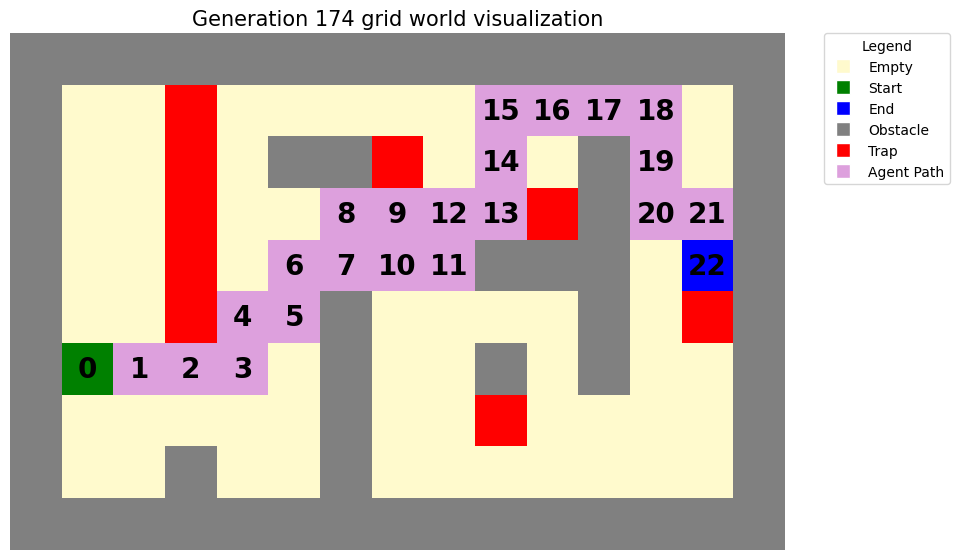

----------------------------------------------------------------------------------------------------

8. generation 203 grid world


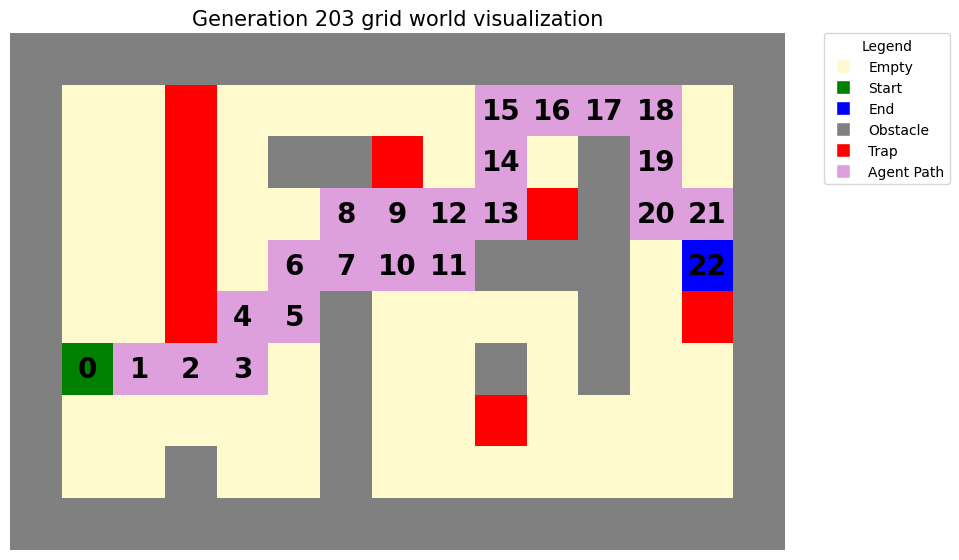

----------------------------------------------------------------------------------------------------

9. generation 232 grid world


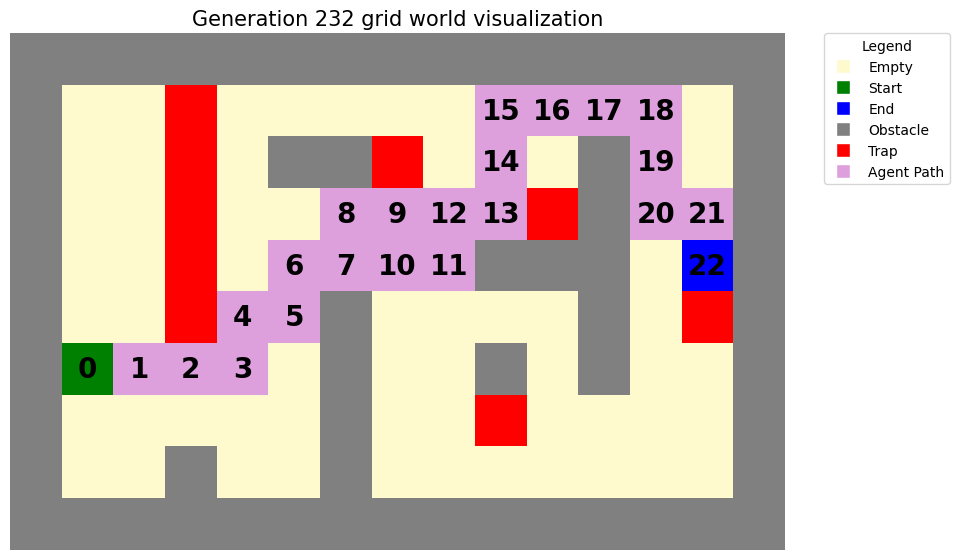

----------------------------------------------------------------------------------------------------

10. generation 261 grid world


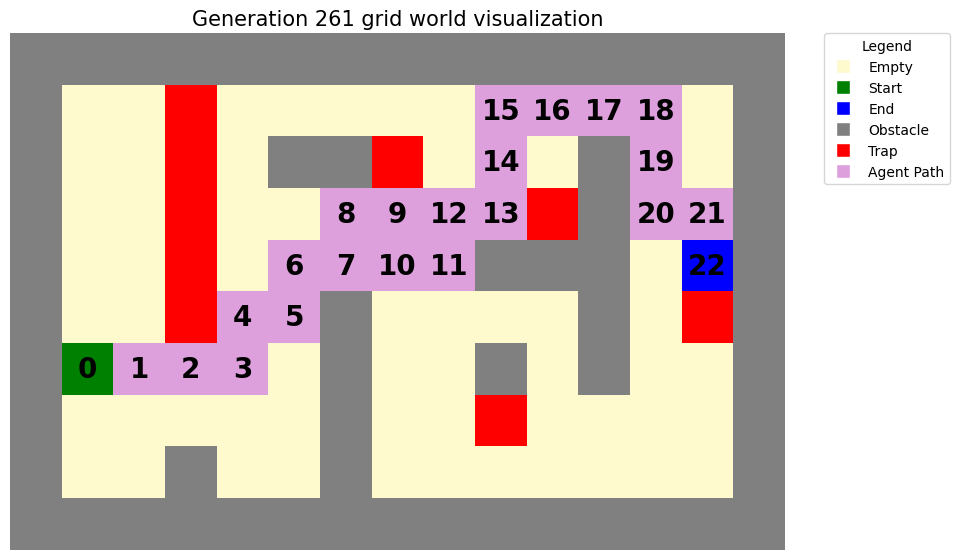

----------------------------------------------------------------------------------------------------

11. generation 290 grid world


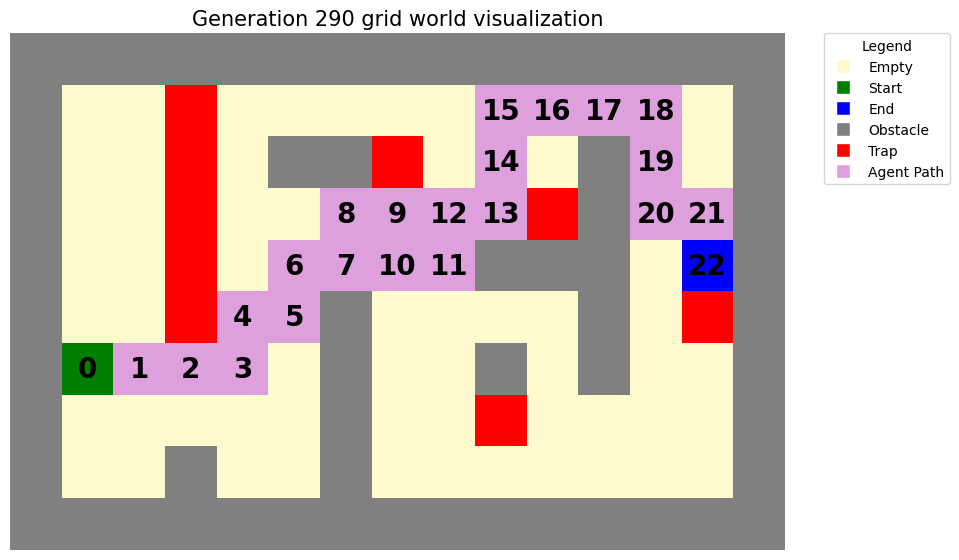

----------------------------------------------------------------------------------------------------

12. generation 294 grid world


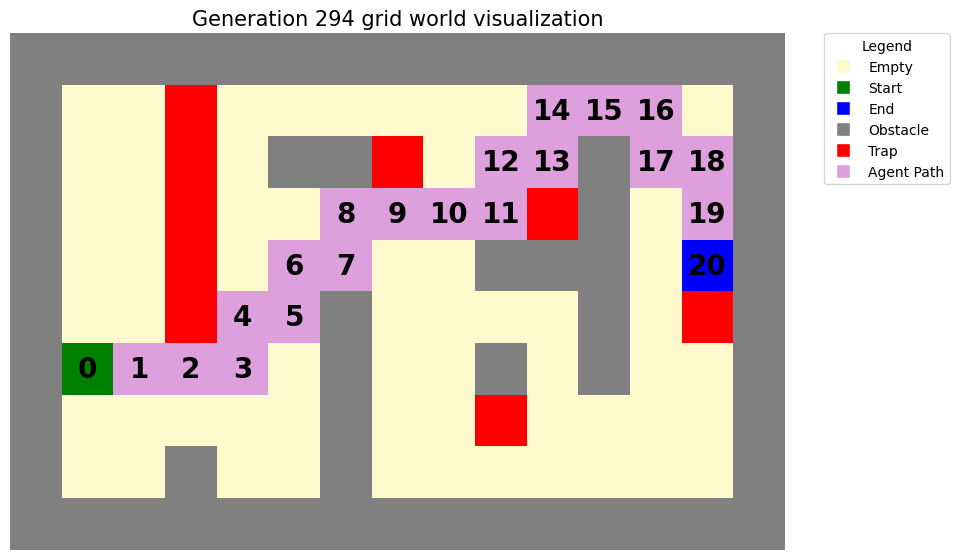

----------------------------------------------------------------------------------------------------



In [8]:
generation_step = generation // 10

counter = 1
for generation, grid_world in enumerate(best_grid_worlds, 1):
    if generation == 1 or generation == best_generation or generation%generation_step == 0:
        print(f"{counter}. generation {generation} grid world")
        title = f"Generation {generation} grid world visualization"
        fn.grid_world_visualization(grid_world, agent_path=best_population_paths[generation-1], title=title, agent_flag=1)
        print(LINE)
        print()
        counter += 1

In [9]:
print(DOUBLE_LINE)
print("PATHS RECONSTRUCTION AND VIDEO CREATION")
print(DOUBLE_LINE)
print("Path reconstruction:")
fn.path_reconstruction(
    best_population_paths=best_population_paths, 
    initial_grid_world=initial_grid_world, 
    results_path=ALL_TO_ALL_RESULTS_PATH, 
    start_position=START_POSITION, 
    end_position=END_POSITION, 
    step=generation_step, 
    title_type="generation", 
    path_flag=1
)
print(LINE)
print("Video creation...")
fn.video_creation(ALL_TO_ALL_RESULTS_PATH, ALL_TO_ALL_VIDEO_PATH)
print("Video creation finished!")
print(DOUBLE_LINE)

PATHS RECONSTRUCTION AND VIDEO CREATION
Path reconstruction:


Processing generations/iterations: 100%|██████████| 12/12 [02:13<00:00, 11.15s/it]


----------------------------------------------------------------------------------------------------
Video creation...


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


Video saved to ./results/GA results/regular mutation/all_to_all_results.mp4
Video creation finished!


frame=  266 fps=157 q=-1.0 Lsize=     396kB time=00:00:52.60 bitrate=  61.7kbits/s speed=31.1x    
video:393kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.778931%
[libx264 @ 0x564daddbe180] frame I:2     Avg QP: 8.29  size: 22221
[libx264 @ 0x564daddbe180] frame P:200   Avg QP:17.12  size:  1632
[libx264 @ 0x564daddbe180] frame B:64    Avg QP:13.42  size:   490
[libx264 @ 0x564daddbe180] consecutive B-frames: 57.9% 28.6%  4.5%  9.0%
[libx264 @ 0x564daddbe180] mb I  I16..4: 81.6%  5.5% 12.9%
[libx264 @ 0x564daddbe180] mb P  I16..4:  1.2%  0.4%  0.7%  P16..4:  1.3%  0.2%  0.1%  0.0%  0.0%    skip:96.2%
[libx264 @ 0x564daddbe180] mb B  I16..4:  0.9%  0.2%  0.2%  B16..8:  2.0%  0.1%  0.0%  direct: 0.2%  skip:96.2%  L0:52.4% L1:46.9% BI: 0.7%
[libx264 @ 0x564daddbe180] 8x8 transform intra:14.6% inter:51.6%
[libx264 @ 0x564daddbe180] coded y,uvDC,uvAC intra: 13.9% 35.7% 29.3% inter: 0.4% 0.7% 0.5%
[libx264 @ 0x564daddbe180] i16 v,h,dc,p: 66% 33%  2%  0%
[li

In [10]:
Video(ALL_TO_ALL_VIDEO_PATH, embed=True)

## All to the best ones crossover case

### Simulation

In [ ]:
print(DOUBLE_LINE)
print(SIMULATION_STARTED)
print(DOUBLE_LINE)

start_time = time.time()

num_best = int(POPULATION_SIZE * BEST_ONES_PERCENTAGE)
num_rest = POPULATION_SIZE - num_best

best_scores = []
secondary_scores_of_best = []
median_scores = []
mean_scores = []
best_grid_worlds = []
best_population_paths = []
best_generation = NUM_GENERATIONS
first_full_path_generation = 0
mutation_rate = 0
converge_flag = False

for generation in range(1, NUM_GENERATIONS+1):
    if generation == 1:
        population = [fn.generate_agent(CHROMOSOME_LENGTH, random_seed=i) for i in range(POPULATION_SIZE)]
    else:
        population = []

        best_individuals = population_sorted[:num_best]
        rest_individuals = population_sorted[num_best:]
        for i in range(int(POPULATION_SIZE/2)):
            agent1 = fn.selection(best_individuals, mode="uniform", random_seed=i)
            agent2 = fn.selection(rest_individuals, bias=BIAS, mode="rank-based", random_seed=i*42+42)

            new_agent1, new_agent2 = fn.crossover(agent1, agent2, random_seed=i)

            if PROGRESSIVE_MUTATION and mutation_rate < 0.1 and fn.check_last_n_generations_same(best_scores, secondary_scores_of_best):
                mutation_rate += MUTATION_RATE
            else:
                mutation_rate = MUTATION_RATE

            mutated_new_agent1 = fn.mutate(new_agent1, mutation_probability=mutation_rate, random_seed=i)
            mutated_new_agent2 = fn.mutate(new_agent2, mutation_probability=mutation_rate, random_seed=i**2)

            population.extend([mutated_new_agent1, mutated_new_agent2])

    primary_fitness_scores = []
    secondary_fitness_scores = []
    grid_worlds = []
    population_paths = []

    for agent in population:
        primary_fitness_score, secondary_fitness_score, grid_world, path = fn.fitness_score_calculation(
            agent_path=agent, 
            grid_world=initial_grid_world, 
            chromosome_length=CHROMOSOME_LENGTH, 
            start_position=START_POSITION, 
            end_position=END_POSITION, 
            penalty_coefficients=PENALTY_COEFFICIENTS, 
            grid_size=GRID_SIZE
        )
        
        primary_fitness_scores.append(primary_fitness_score)
        secondary_fitness_scores.append(secondary_fitness_score)
        grid_worlds.append(grid_world)
        population_paths.append(path)

    population_sorted, indices_sorted = fn.population_sorting(population, primary_fitness_scores, secondary_fitness_scores)

    best_score = np.min(np.array(primary_fitness_scores))
    secondary_score_of_best = secondary_fitness_scores[indices_sorted[0]]
    median_score = round(np.median(np.array(primary_fitness_scores)),4)
    mean_score = round(np.mean(np.array(primary_fitness_scores)), 4)
    best_grid_world = grid_worlds[indices_sorted[0]]
    best_agent_path = population_paths[indices_sorted[0]]

    best_scores.append(best_score)
    secondary_scores_of_best.append(secondary_score_of_best)
    median_scores.append(median_score)
    mean_scores.append(mean_score)
    best_population_paths.append(best_agent_path)
    best_grid_worlds.append(best_grid_world)

    if generation == 1 or generation % 10 == 0:
        print(f" {generation}. generation finished - best score: {best_score} - median score: {median_score} - mean score: {mean_score} - steps: {secondary_score_of_best}")
        print(LINE)

    if best_score == 0:
        if not first_full_path_generation:
            first_full_path_generation = generation
    
        if EARLY_STOP or secondary_score_of_best == NUM_OPTIMAL_STEPS:
            converge_flag = True
            best_generation = generation
            print(f" {generation}. generation finished - best score: {best_score} - median score: {median_score} - mean score: {mean_score} - steps: {secondary_score_of_best}")
            print(LINE)
            break

_, best_indices_sorted = fn.population_sorting(best_population_paths, best_scores, secondary_scores_of_best)
best_generation = best_indices_sorted[0] + 1
final_best_score = best_scores[best_indices_sorted[0]]
final_best_secondary_score = secondary_scores_of_best[best_indices_sorted[0]]

end_time = time.time()

if not converge_flag:
    print("Optimal path is not found!")

print(f"The best generation: {best_generation}")
print(f"The best primary score: {final_best_score}")
print(f"The best secondary score: {final_best_secondary_score}")
print(f"The first full path generation: {first_full_path_generation}")

formatted_total_time, time_per_iteration, iterations_per_second = fn.create_time_report(start_time, end_time, NUM_GENERATIONS)

print(DOUBLE_LINE)
print(SIMULATION_FINISHED)
print(DOUBLE_LINE)

------------------------------------ !!! SIMULATION STARTED !!! ------------------------------------
 1. generation finished - best score: 7.0711 - median score: 13.0384 - mean score: 12.2551 - steps: 14
----------------------------------------------------------------------------------------------------
 10. generation finished - best score: 2.2361 - median score: 3.1623 - mean score: 4.3127 - steps: 13
----------------------------------------------------------------------------------------------------
 20. generation finished - best score: 2.2361 - median score: 2.2361 - mean score: 3.6864 - steps: 13
----------------------------------------------------------------------------------------------------
 30. generation finished - best score: 2.2361 - median score: 2.2361 - mean score: 3.6893 - steps: 13
----------------------------------------------------------------------------------------------------
 40. generation finished - best score: 2.2361 - median score: 2.2361 - mean score: 3.6

### Result scores visualization

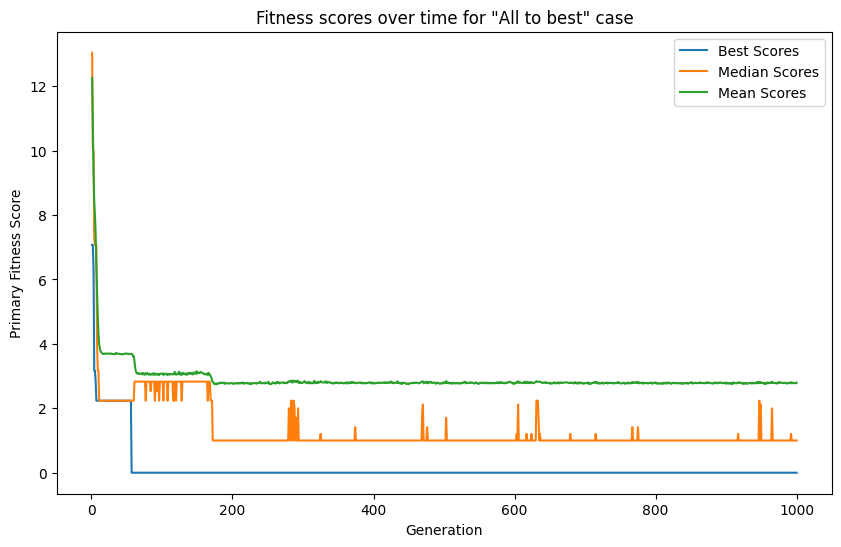

In [12]:
x_values = range(1, len(best_scores)+1)

plt.figure(figsize=(10, 6))

plt.plot(x_values, best_scores, label="Best Scores")
plt.plot(x_values, median_scores, label="Median Scores")
plt.plot(x_values, mean_scores, label="Mean Scores")

plt.title("Fitness scores over time for \"All to best\" case")
plt.xlabel("Generation")
plt.ylabel("Primary Fitness Score")
plt.legend()

plt.show()

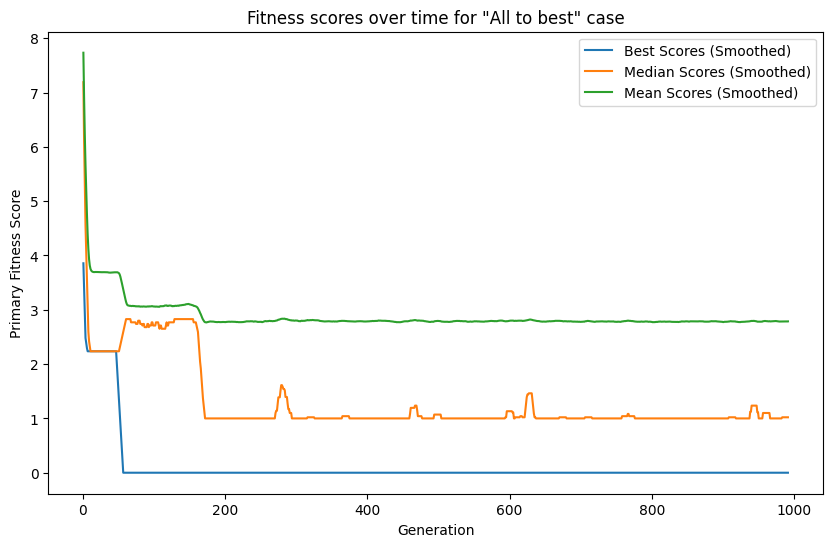

In [13]:
best_scores_smooth = fn.moving_average(best_scores, WINDOW_SIZE)
median_scores_smooth = fn.moving_average(median_scores, WINDOW_SIZE)
mean_scores_smooth = fn.moving_average(mean_scores, WINDOW_SIZE)

x_values_smooth = range(1, len(best_scores_smooth) + 1)

plt.figure(figsize=(10, 6))

plt.plot(x_values_smooth, best_scores_smooth, label="Best Scores (Smoothed)")
plt.plot(x_values_smooth, median_scores_smooth, label="Median Scores (Smoothed)")
plt.plot(x_values_smooth, mean_scores_smooth, label="Mean Scores (Smoothed)")

plt.title("Fitness scores over time for \"All to best\" case")
plt.xlabel("Generation")
plt.ylabel("Primary Fitness Score")
plt.legend()

plt.show()

### Grid world path optimization evolution

1. generation 1 grid world


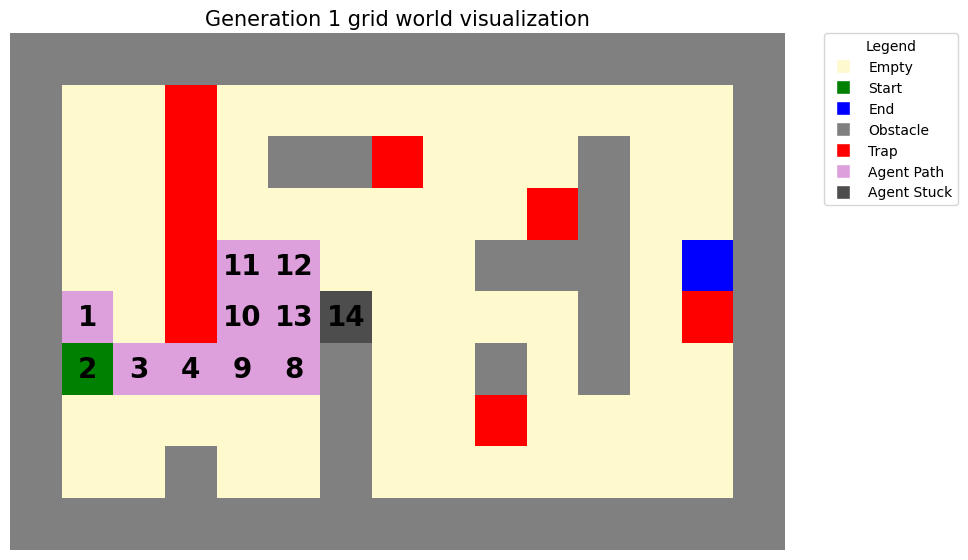

----------------------------------------------------------------------------------------------------

2. generation 100 grid world


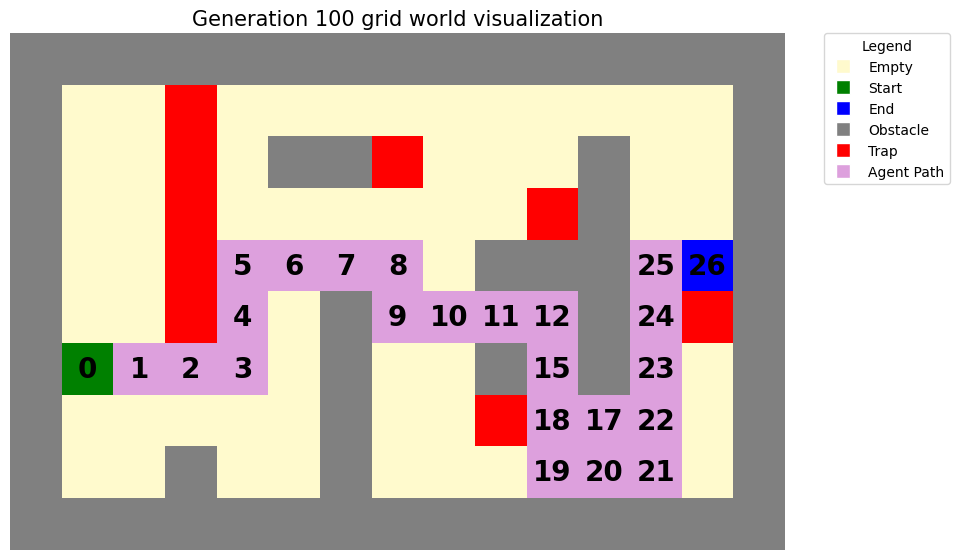

----------------------------------------------------------------------------------------------------

3. generation 166 grid world


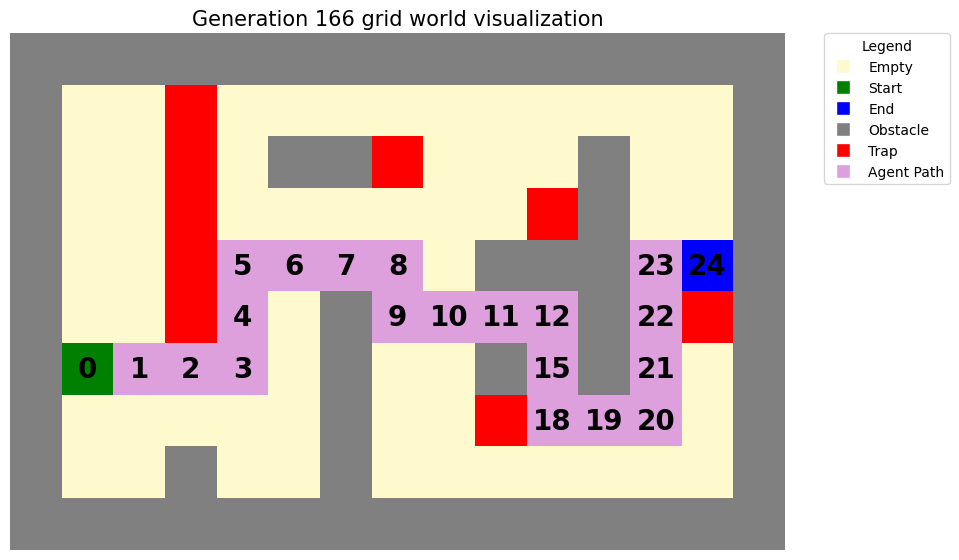

----------------------------------------------------------------------------------------------------

4. generation 200 grid world


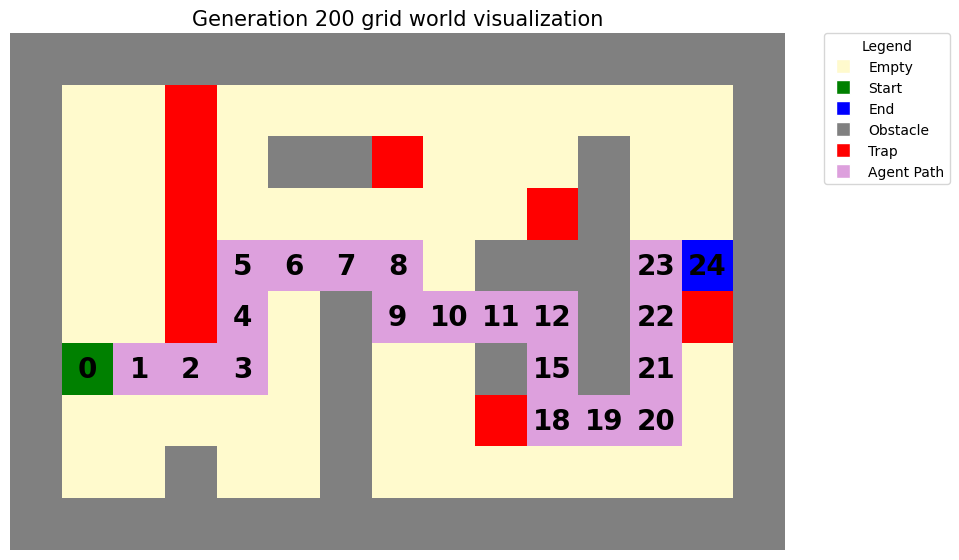

----------------------------------------------------------------------------------------------------

5. generation 300 grid world


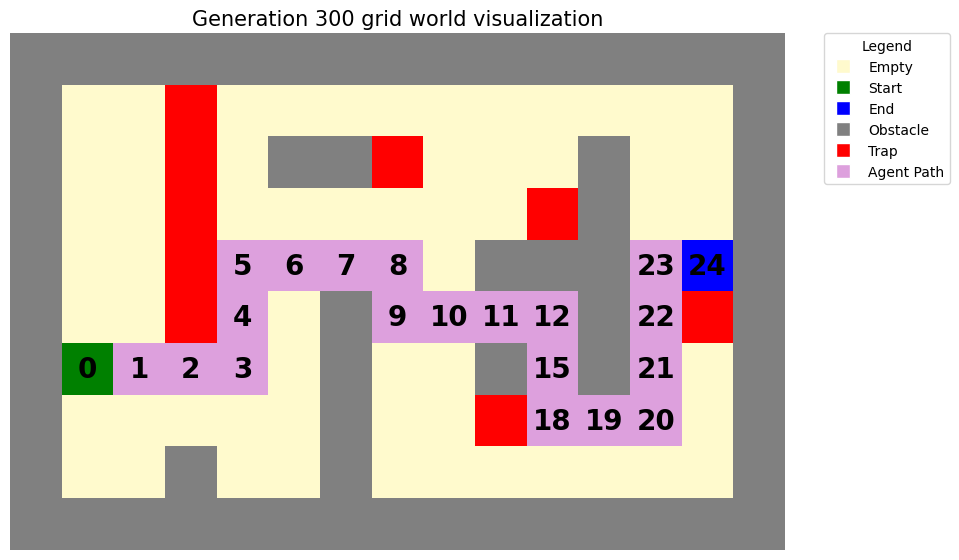

----------------------------------------------------------------------------------------------------

6. generation 400 grid world


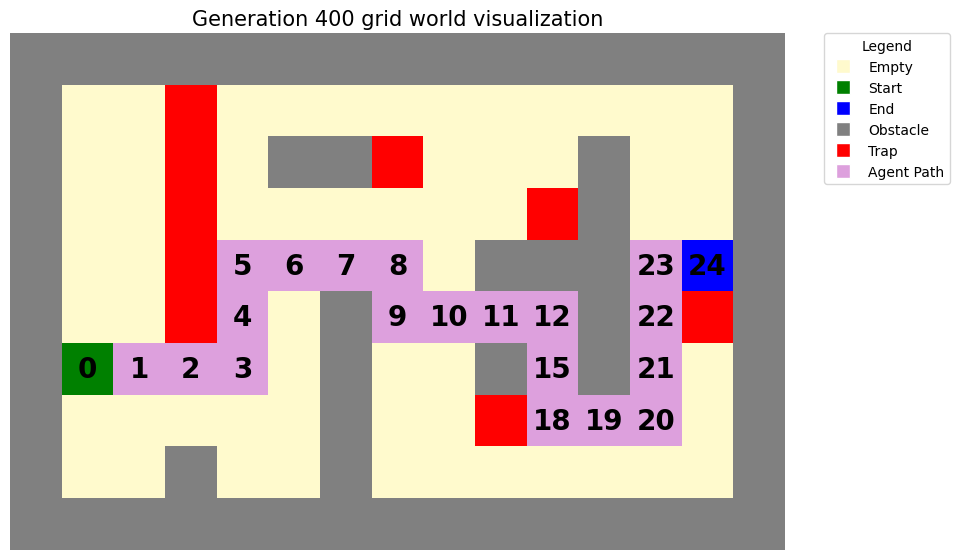

----------------------------------------------------------------------------------------------------

7. generation 500 grid world


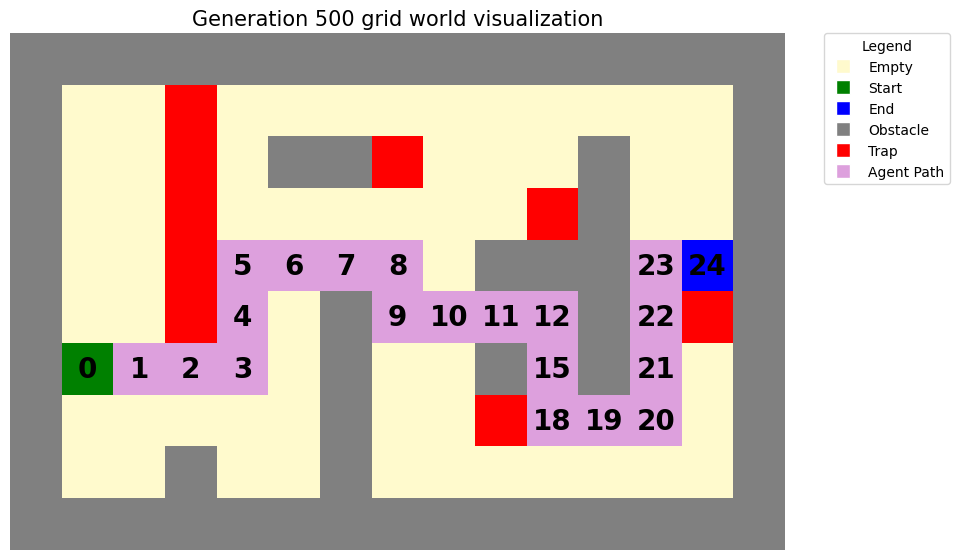

----------------------------------------------------------------------------------------------------

8. generation 600 grid world


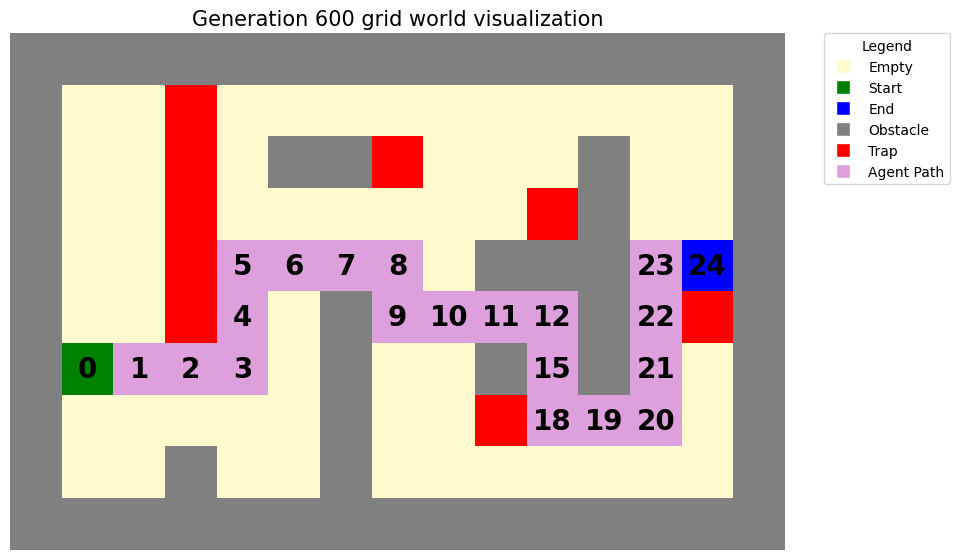

----------------------------------------------------------------------------------------------------

9. generation 700 grid world


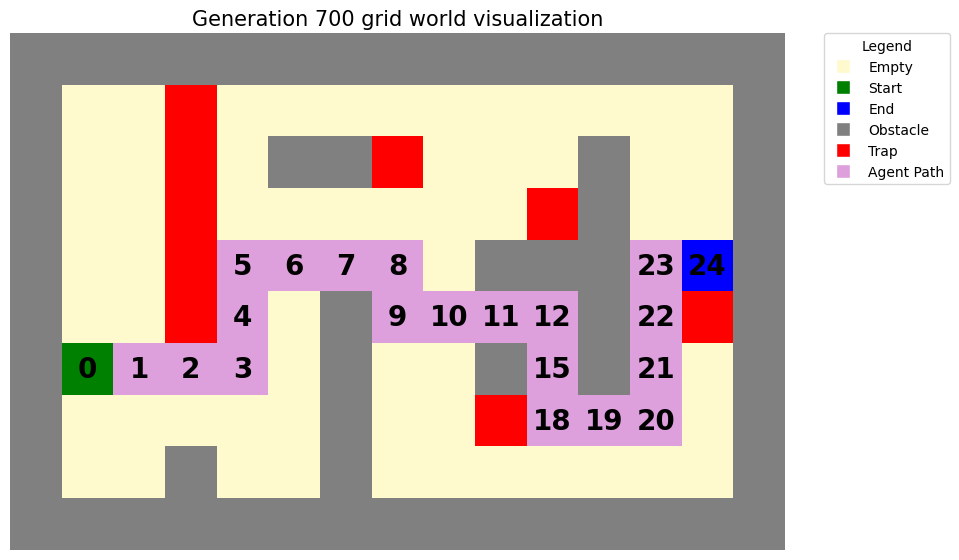

----------------------------------------------------------------------------------------------------

10. generation 800 grid world


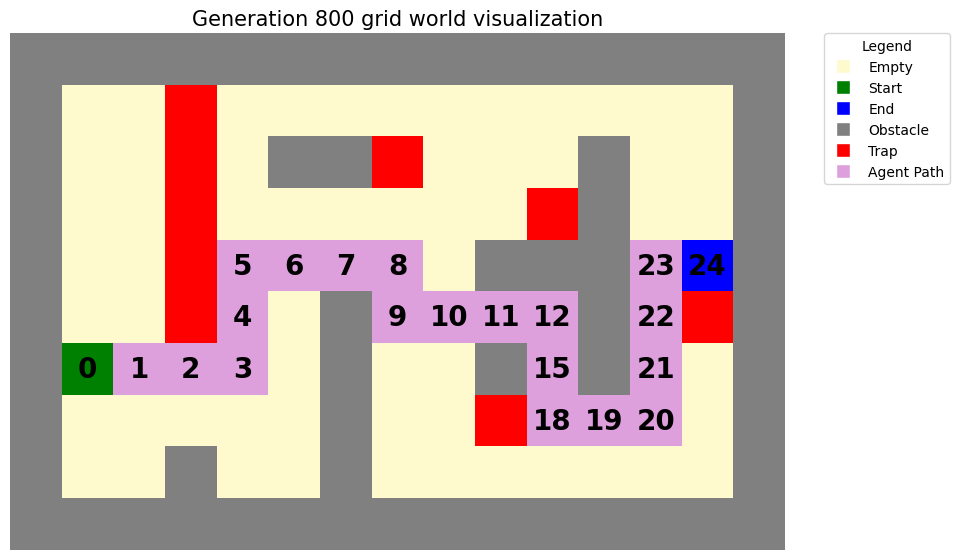

----------------------------------------------------------------------------------------------------

11. generation 900 grid world


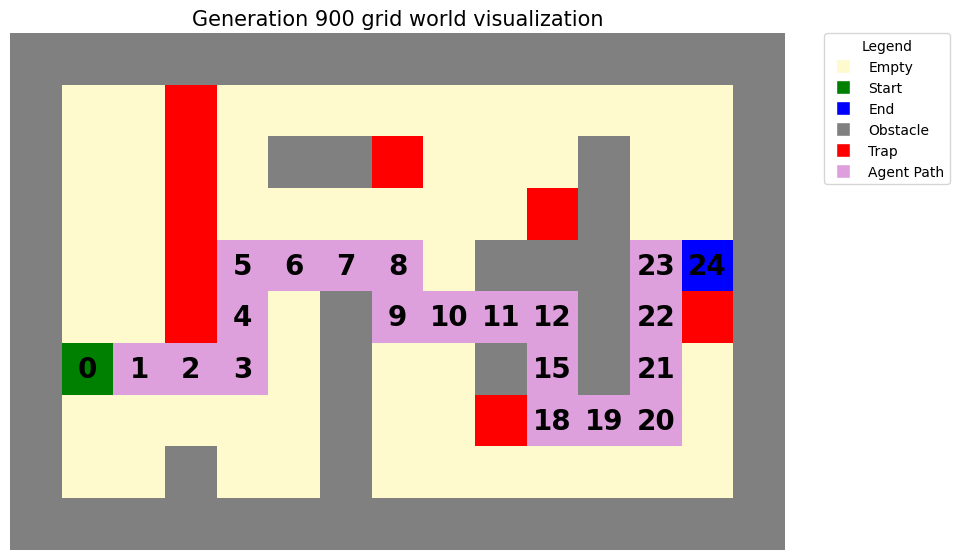

----------------------------------------------------------------------------------------------------

12. generation 1000 grid world


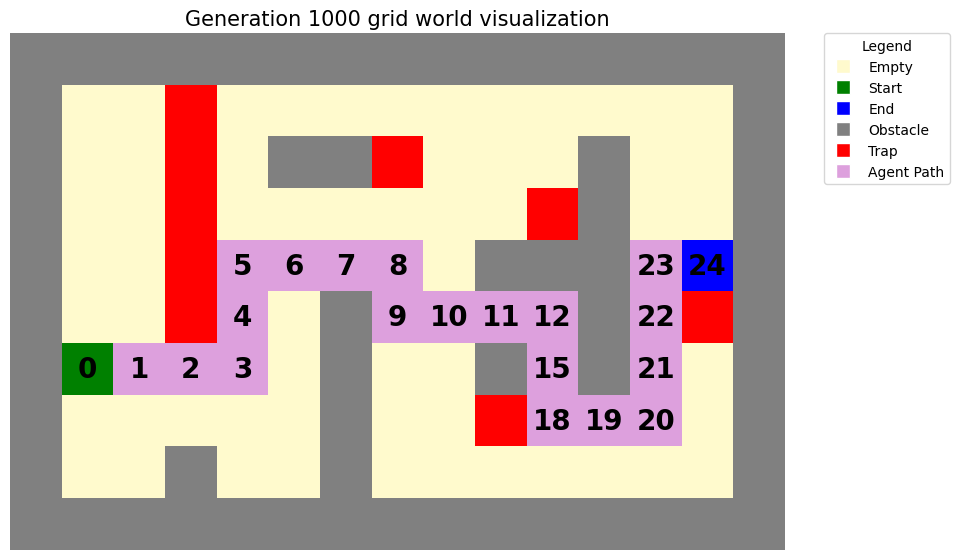

----------------------------------------------------------------------------------------------------



In [14]:
generation_step = generation // 10

counter = 1
for generation, grid_world in enumerate(best_grid_worlds, 1):
    if generation == 1 or generation == best_generation or generation%generation_step == 0:
        print(f"{counter}. generation {generation} grid world")
        title = f"Generation {generation} grid world visualization"
        fn.grid_world_visualization(grid_world, agent_path=best_population_paths[generation-1], title=title, agent_flag=1)
        print(LINE)
        print()
        counter += 1

In [15]:
print(DOUBLE_LINE)
print("PATHS RECONSTRUCTION AND VIDEO CREATION")
print(DOUBLE_LINE)
print("Path reconstruction:")
fn.path_reconstruction(
    best_population_paths=best_population_paths, 
    initial_grid_world=initial_grid_world, 
    results_path=ALL_TO_BEST_RESULTS_PATH, 
    start_position=START_POSITION, 
    end_position=END_POSITION, 
    step=generation_step, 
    title_type="generation", 
    path_flag=1
)
print(LINE)
print("Video creation...")
fn.video_creation(ALL_TO_BEST_RESULTS_PATH, ALL_TO_BEST_VIDEO_PATH)
print("Video creation finished!")
print(DOUBLE_LINE)

PATHS RECONSTRUCTION AND VIDEO CREATION
Path reconstruction:


Processing generations/iterations: 100%|██████████| 11/11 [01:53<00:00, 10.28s/it]


----------------------------------------------------------------------------------------------------
Video creation...


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


Video saved to ./results/GA results/regular mutation/all_to_best_results.mp4
Video creation finished!


frame=  267 fps=198 q=-1.0 Lsize=     370kB time=00:00:52.80 bitrate=  57.4kbits/s speed=39.2x    
video:366kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.933767%
[libx264 @ 0x558e0613c180] frame I:2     Avg QP: 8.36  size: 22910
[libx264 @ 0x558e0613c180] frame P:157   Avg QP:14.37  size:  1763
[libx264 @ 0x558e0613c180] frame B:108   Avg QP:13.06  size:   480
[libx264 @ 0x558e0613c180] consecutive B-frames: 29.2% 40.4% 30.3%  0.0%
[libx264 @ 0x558e0613c180] mb I  I16..4: 81.1%  5.7% 13.2%
[libx264 @ 0x558e0613c180] mb P  I16..4:  1.1%  0.6%  0.8%  P16..4:  1.3%  0.2%  0.1%  0.0%  0.0%    skip:96.0%
[libx264 @ 0x558e0613c180] mb B  I16..4:  0.7%  0.2%  0.2%  B16..8:  2.0%  0.1%  0.0%  direct: 0.2%  skip:96.5%  L0:56.6% L1:42.6% BI: 0.8%
[libx264 @ 0x558e0613c180] 8x8 transform intra:17.9% inter:55.9%
[libx264 @ 0x558e0613c180] coded y,uvDC,uvAC intra: 14.2% 34.1% 29.2% inter: 0.4% 0.7% 0.5%
[libx264 @ 0x558e0613c180] i16 v,h,dc,p: 68% 31%  1%  0%
[li

In [16]:
Video(ALL_TO_BEST_VIDEO_PATH, embed=True)

## Hybrid evolutionary case

### Simulation

In [ ]:
print(DOUBLE_LINE)
print(SIMULATION_STARTED)
print(DOUBLE_LINE)

start_time = time.time()

num_best = int(POPULATION_SIZE * BEST_ONES_PERCENTAGE)
num_worst = int(POPULATION_SIZE * WORST_ONES_PERCENTAGE)
num_middle = POPULATION_SIZE - num_best - num_worst

best_scores = []
secondary_scores_of_best = []
median_scores = []
mean_scores = []
best_grid_worlds = []
best_population_paths = []
best_generation = NUM_GENERATIONS
first_full_path_generation = 0
mutation_rate = 0
converge_flag = False

for generation in range(1, NUM_GENERATIONS+1):
    if generation == 1:
        population = [fn.generate_agent(CHROMOSOME_LENGTH, random_seed=i) for i in range(POPULATION_SIZE)]
    else:
        population = []

        best_individuals = population_sorted[:num_best]
        middle_individuals = population_sorted[num_best:num_best+num_middle]
        worst_individuals = population_sorted[-num_worst:]

        population.extend(best_individuals)

        for i in range(int(num_middle / 2)):
            agent1 = fn.selection(best_individuals, mode="uniform", random_seed=i)
            agent2 = fn.selection(middle_individuals, bias=BIAS, mode="rank-based", random_seed=i * 42 + 42)

            new_agent1, new_agent2 = fn.crossover(agent1, agent2, random_seed=i)

            if PROGRESSIVE_MUTATION and mutation_rate < 0.1 and fn.check_last_n_generations_same(best_scores, secondary_scores_of_best):
                mutation_rate += MUTATION_RATE
            else:
                mutation_rate = MUTATION_RATE

            mutated_new_agent1 = fn.mutate(new_agent1, mutation_probability=mutation_rate, random_seed=i)
            mutated_new_agent2 = fn.mutate(new_agent2, mutation_probability=mutation_rate, random_seed=i**2)

            population.extend([mutated_new_agent1, mutated_new_agent2])

        worst_replacements = [fn.generate_agent(CHROMOSOME_LENGTH, random_seed=i + POPULATION_SIZE) for i in range(num_worst)]
        population.extend(worst_replacements)

    primary_fitness_scores = []
    secondary_fitness_scores = []
    grid_worlds = []
    population_paths = []

    for agent in population:
        primary_fitness_score, secondary_fitness_score, grid_world, path = fn.fitness_score_calculation(
            agent_path=agent, 
            grid_world=initial_grid_world, 
            chromosome_length=CHROMOSOME_LENGTH, 
            start_position=START_POSITION, 
            end_position=END_POSITION, 
            penalty_coefficients=PENALTY_COEFFICIENTS, 
            grid_size=GRID_SIZE
        )
        
        primary_fitness_scores.append(primary_fitness_score)
        secondary_fitness_scores.append(secondary_fitness_score)
        grid_worlds.append(grid_world)
        population_paths.append(path)

    population_sorted, indices_sorted = fn.population_sorting(population, primary_fitness_scores, secondary_fitness_scores)

    best_score = np.min(np.array(primary_fitness_scores))
    secondary_score_of_best = secondary_fitness_scores[indices_sorted[0]]
    median_score = round(np.median(np.array(primary_fitness_scores)),4)
    mean_score = round(np.mean(np.array(primary_fitness_scores)), 4)
    best_grid_world = grid_worlds[indices_sorted[0]]
    best_agent_path = population_paths[indices_sorted[0]]

    best_scores.append(best_score)
    secondary_scores_of_best.append(secondary_score_of_best)
    median_scores.append(median_score)
    mean_scores.append(mean_score)
    best_population_paths.append(best_agent_path)
    best_grid_worlds.append(best_grid_world)

    if generation == 1 or generation % 10 == 0:
        print(f" {generation}. generation finished - best score: {best_score} - median score: {median_score} - mean score: {mean_score} - steps: {secondary_score_of_best}")
        print(LINE)

    if best_score == 0:
        if not first_full_path_generation:
            first_full_path_generation = generation
    
        if EARLY_STOP or secondary_score_of_best == NUM_OPTIMAL_STEPS:
            converge_flag = True
            best_generation = generation
            print(f" {generation}. generation finished - best score: {best_score} - median score: {median_score} - mean score: {mean_score} - steps: {secondary_score_of_best}")
            print(LINE)
            break

_, best_indices_sorted = fn.population_sorting(best_population_paths, best_scores, secondary_scores_of_best)
best_generation = best_indices_sorted[0] + 1
final_best_score = best_scores[best_indices_sorted[0]]
final_best_secondary_score = secondary_scores_of_best[best_indices_sorted[0]]

end_time = time.time()

if not converge_flag:
    print("Optimal path is not found!")

print(f"The best generation: {best_generation}")
print(f"The best primary score: {final_best_score}")
print(f"The best secondary score: {final_best_secondary_score}")
print(f"The first full path generation: {first_full_path_generation}")

formatted_total_time, time_per_iteration, iterations_per_second = fn.create_time_report(start_time, end_time, NUM_GENERATIONS)

print(DOUBLE_LINE)
print(SIMULATION_FINISHED)
print(DOUBLE_LINE)

------------------------------------ !!! SIMULATION STARTED !!! ------------------------------------
 1. generation finished - best score: 7.0711 - median score: 13.0384 - mean score: 12.2551 - steps: 14
----------------------------------------------------------------------------------------------------
 10. generation finished - best score: 0.0 - median score: 5.0 - mean score: 6.3925 - steps: 30
----------------------------------------------------------------------------------------------------
 20. generation finished - best score: 0.0 - median score: 3.1623 - mean score: 5.2484 - steps: 30
----------------------------------------------------------------------------------------------------
 30. generation finished - best score: 0.0 - median score: 3.1623 - mean score: 5.2414 - steps: 30
----------------------------------------------------------------------------------------------------
 40. generation finished - best score: 0.0 - median score: 3.1623 - mean score: 5.26 - steps: 30
-

### Result scores visualization

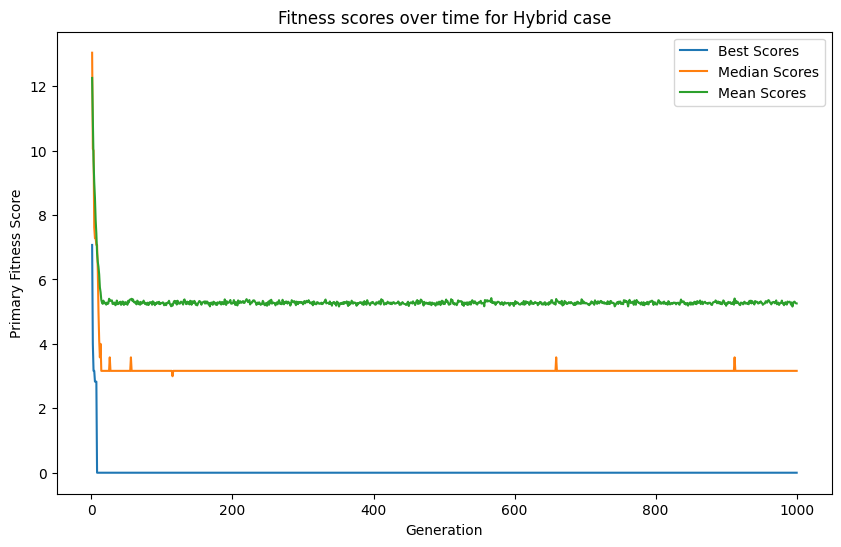

In [18]:
x_values = range(1, len(best_scores)+1)

plt.figure(figsize=(10, 6))

plt.plot(x_values, best_scores, label="Best Scores")
plt.plot(x_values, median_scores, label="Median Scores")
plt.plot(x_values, mean_scores, label="Mean Scores")

plt.title("Fitness scores over time for Hybrid case")
plt.xlabel("Generation")
plt.ylabel("Primary Fitness Score")
plt.legend()

plt.show()

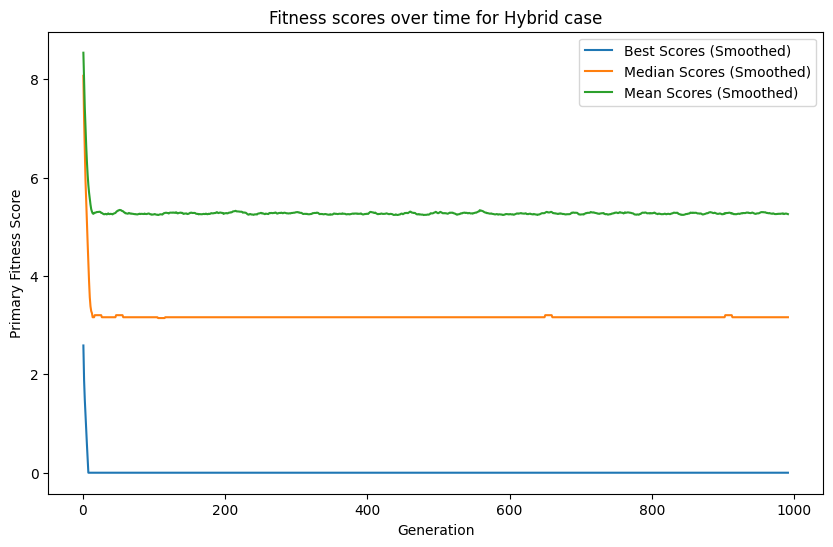

In [19]:
best_scores_smooth = fn.moving_average(best_scores, WINDOW_SIZE)
median_scores_smooth = fn.moving_average(median_scores, WINDOW_SIZE)
mean_scores_smooth = fn.moving_average(mean_scores, WINDOW_SIZE)

x_values_smooth = range(1, len(best_scores_smooth) + 1)

plt.figure(figsize=(10, 6))

plt.plot(x_values_smooth, best_scores_smooth, label="Best Scores (Smoothed)")
plt.plot(x_values_smooth, median_scores_smooth, label="Median Scores (Smoothed)")
plt.plot(x_values_smooth, mean_scores_smooth, label="Mean Scores (Smoothed)")

plt.title("Fitness scores over time for Hybrid case")
plt.xlabel("Generation")
plt.ylabel("Primary Fitness Score")
plt.legend()

plt.show()

### Grid world path optimization evolution

1. generation 1 grid world


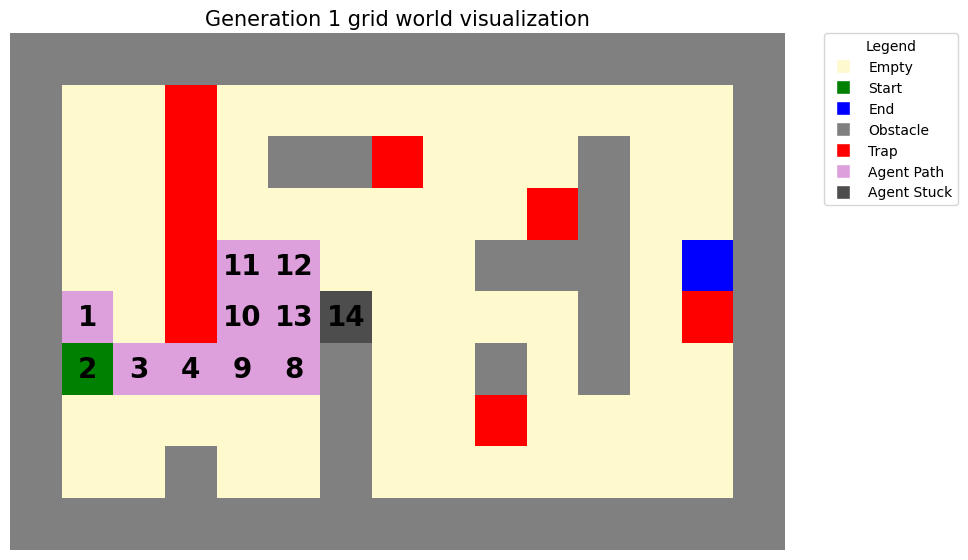

----------------------------------------------------------------------------------------------------

2. generation 8 grid world


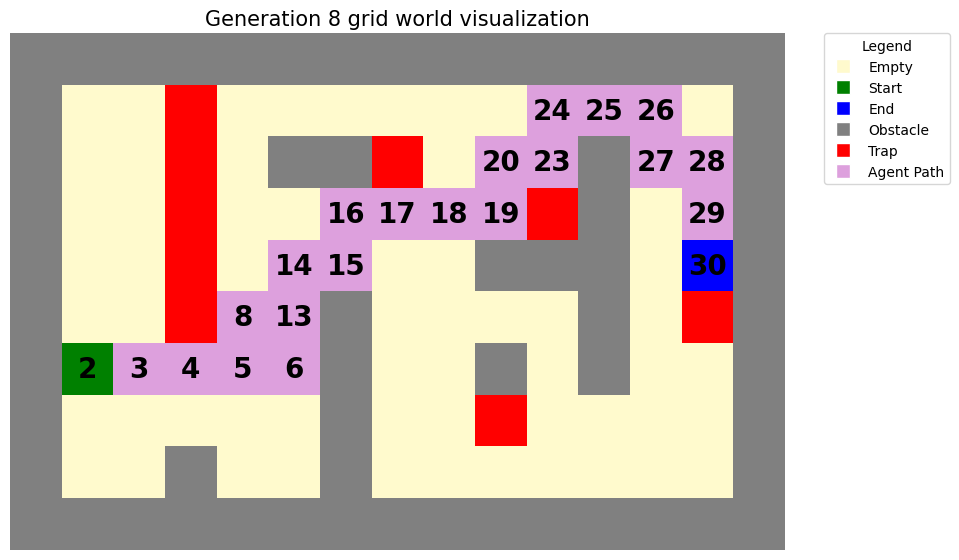

----------------------------------------------------------------------------------------------------

3. generation 100 grid world


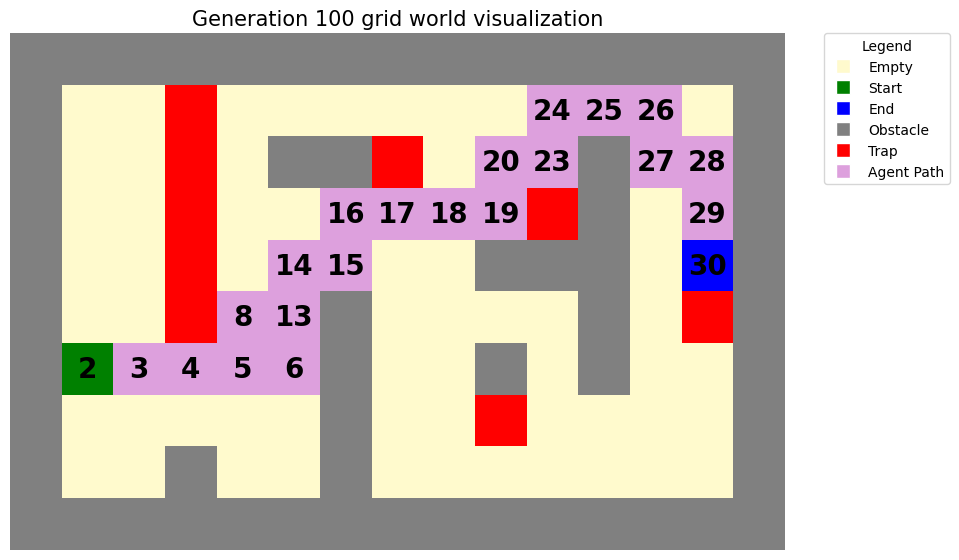

----------------------------------------------------------------------------------------------------

4. generation 200 grid world


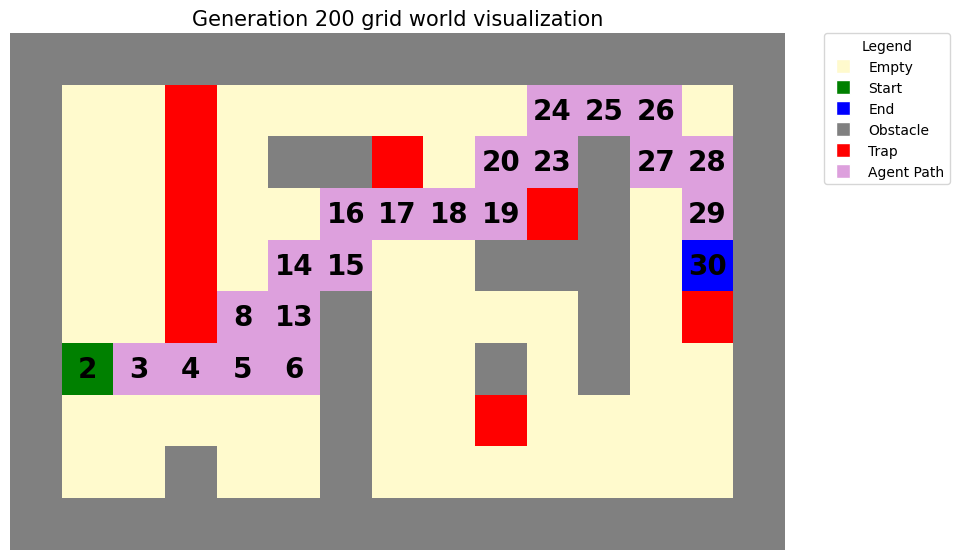

----------------------------------------------------------------------------------------------------

5. generation 300 grid world


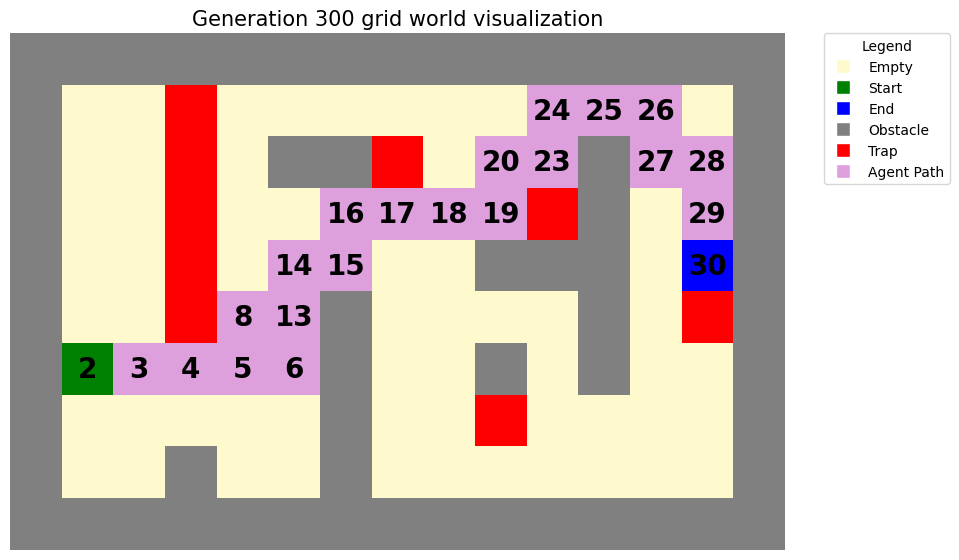

----------------------------------------------------------------------------------------------------

6. generation 400 grid world


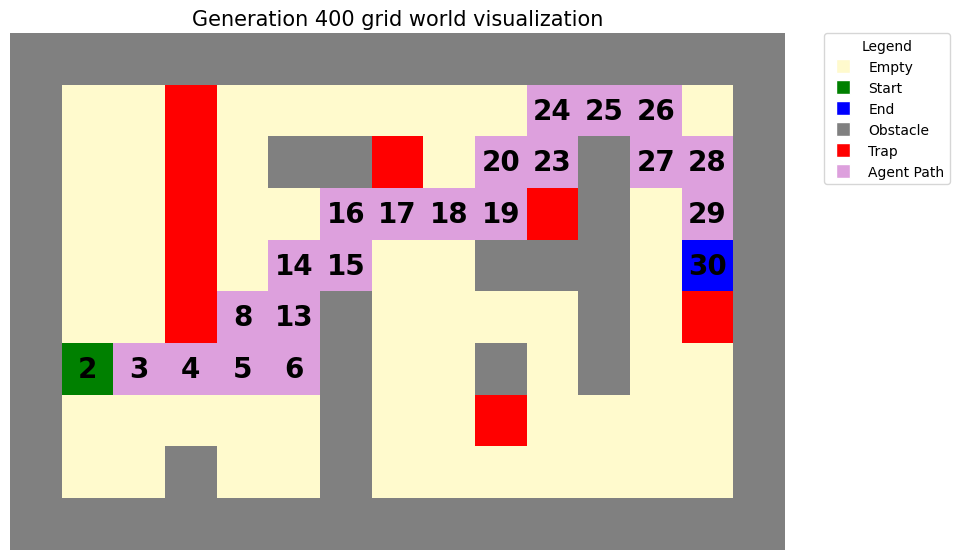

----------------------------------------------------------------------------------------------------

7. generation 500 grid world


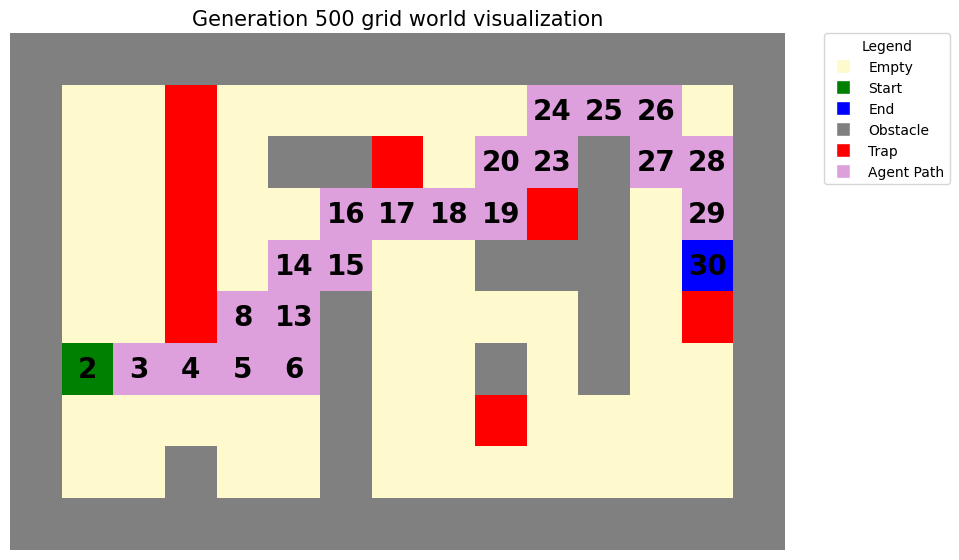

----------------------------------------------------------------------------------------------------

8. generation 600 grid world


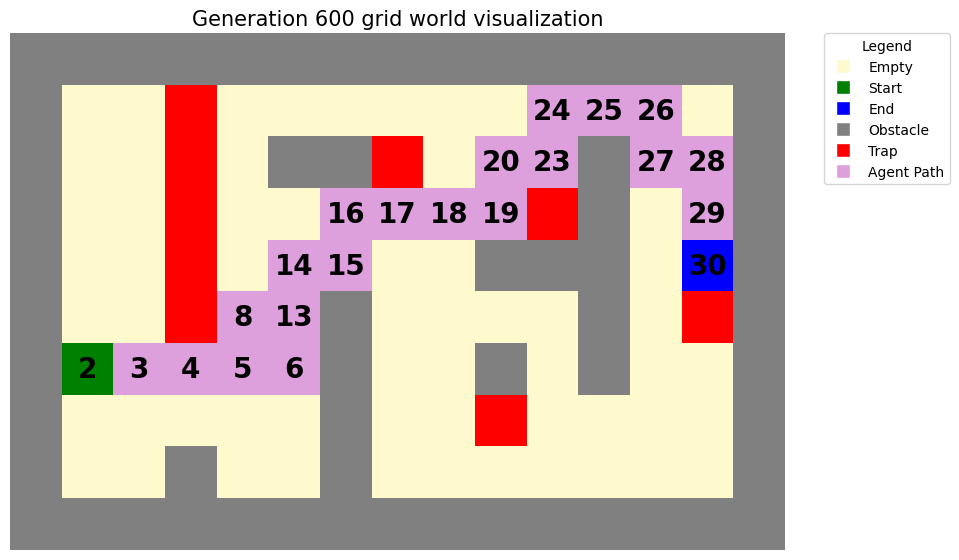

----------------------------------------------------------------------------------------------------

9. generation 700 grid world


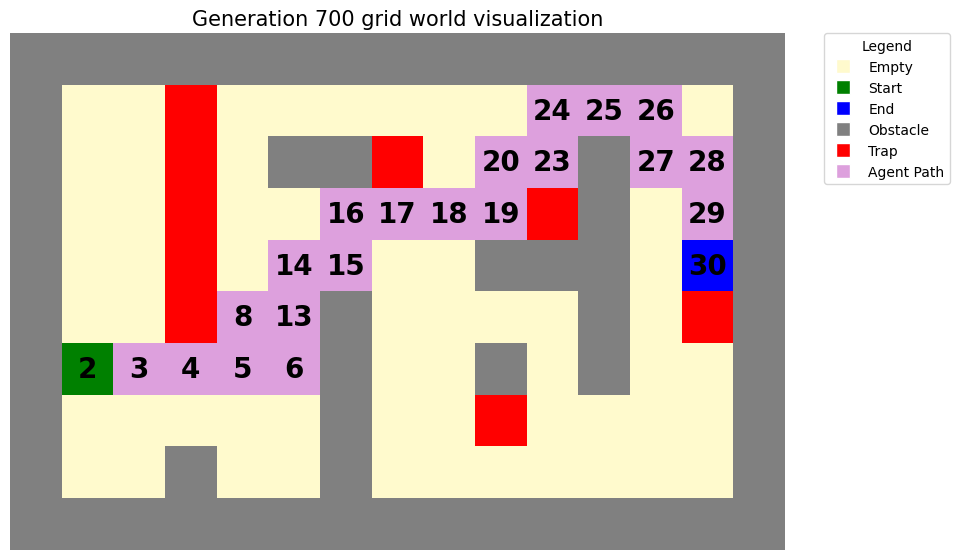

----------------------------------------------------------------------------------------------------

10. generation 800 grid world


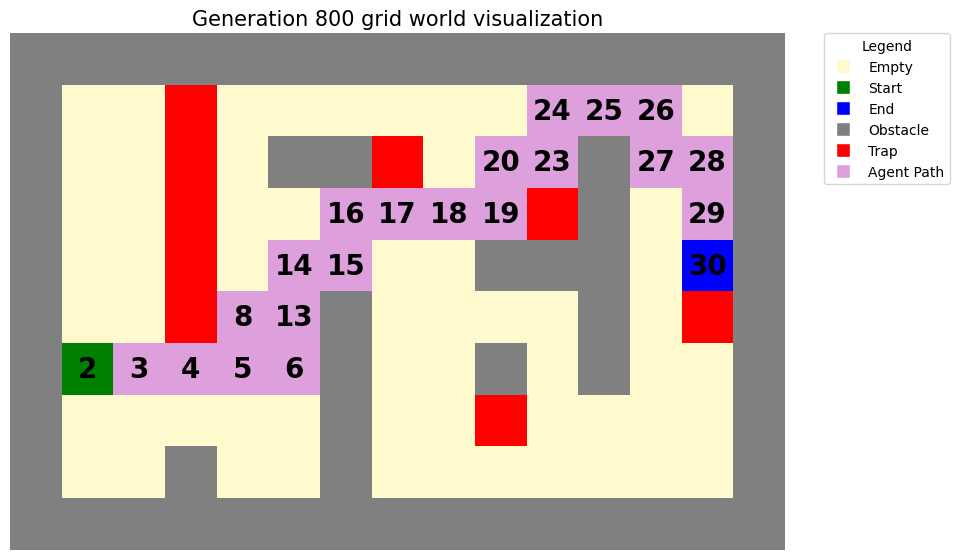

----------------------------------------------------------------------------------------------------

11. generation 900 grid world


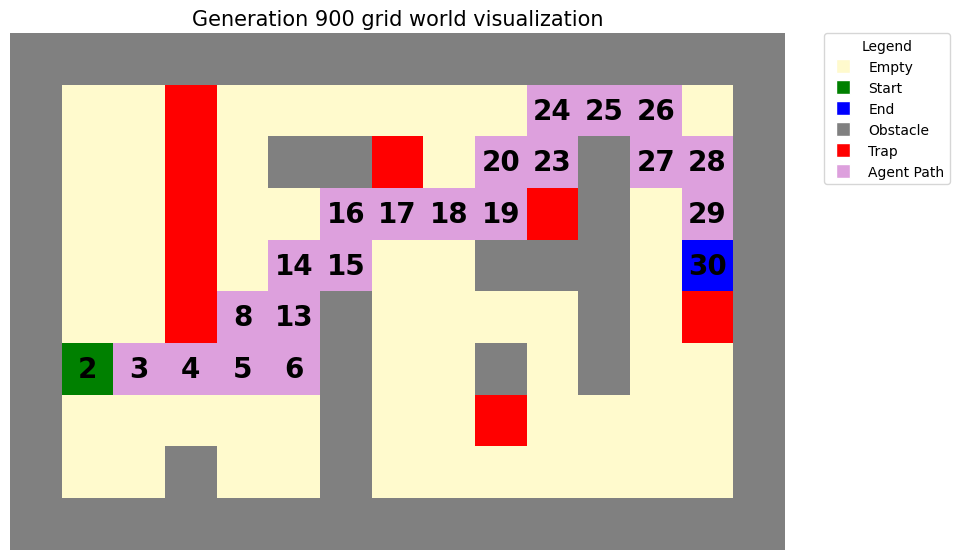

----------------------------------------------------------------------------------------------------

12. generation 1000 grid world


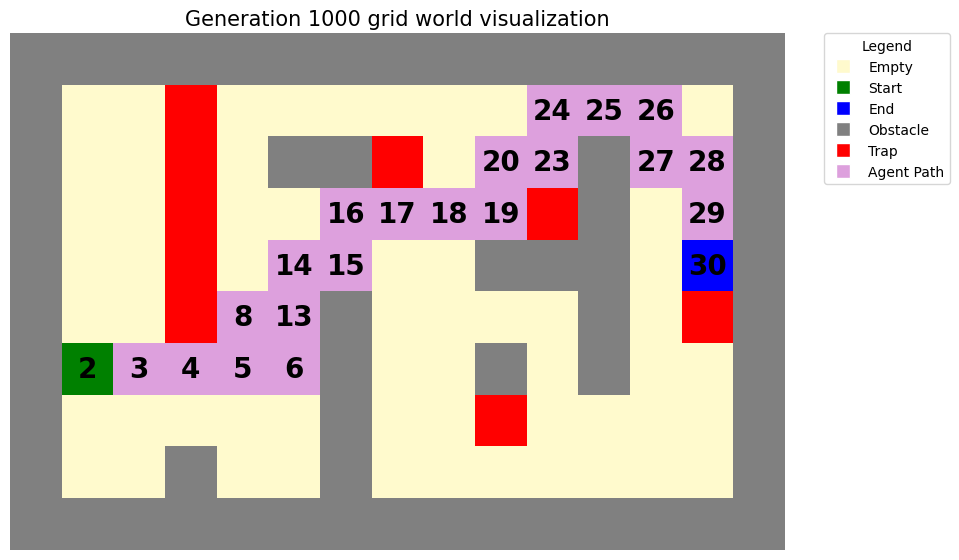

----------------------------------------------------------------------------------------------------



In [20]:
generation_step = generation // 10

counter = 1
for generation, grid_world in enumerate(best_grid_worlds, 1):
    if generation == 1 or generation == best_generation or generation%generation_step == 0:
        print(f"{counter}. generation {generation} grid world")
        title = f"Generation {generation} grid world visualization"
        fn.grid_world_visualization(grid_world, agent_path=best_population_paths[generation-1], title=title, agent_flag=1)
        print(LINE)
        print()
        counter += 1

In [21]:
print(DOUBLE_LINE)
print("PATHS RECONSTRUCTION AND VIDEO CREATION")
print(DOUBLE_LINE)
print("Path reconstruction:")
fn.path_reconstruction(
    best_population_paths=best_population_paths, 
    initial_grid_world=initial_grid_world, 
    results_path=HYBRID_RESULTS_PATH, 
    start_position=START_POSITION, 
    end_position=END_POSITION, 
    step=generation_step, 
    title_type="generation", 
    path_flag=1
)
print(LINE)
print("Video creation...")
fn.video_creation(HYBRID_RESULTS_PATH, HYBRID_VIDEO_PATH)
print("Video creation finished!")
print(DOUBLE_LINE)

PATHS RECONSTRUCTION AND VIDEO CREATION
Path reconstruction:


Processing generations/iterations: 100%|██████████| 11/11 [02:17<00:00, 12.50s/it]


----------------------------------------------------------------------------------------------------
Video creation...


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


Video saved to ./results/GA results/regular mutation/hybrid_results.mp4
Video creation finished!


frame=  325 fps=214 q=-1.0 Lsize=     423kB time=00:01:04.40 bitrate=  53.8kbits/s speed=42.4x    
video:419kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.907009%
[libx264 @ 0x5575dd701380] frame I:2     Avg QP: 7.94  size: 24328
[libx264 @ 0x5575dd701380] frame P:211   Avg QP:16.23  size:  1591
[libx264 @ 0x5575dd701380] frame B:112   Avg QP:13.12  size:   396
[libx264 @ 0x5575dd701380] consecutive B-frames: 40.6% 31.4% 26.8%  1.2%
[libx264 @ 0x5575dd701380] mb I  I16..4: 80.8%  5.8% 13.3%
[libx264 @ 0x5575dd701380] mb P  I16..4:  0.9%  0.4%  0.6%  P16..4:  1.4%  0.2%  0.1%  0.0%  0.0%    skip:96.4%
[libx264 @ 0x5575dd701380] mb B  I16..4:  0.7%  0.1%  0.1%  B16..8:  1.8%  0.1%  0.1%  direct: 0.2%  skip:96.9%  L0:58.9% L1:40.2% BI: 0.9%
[libx264 @ 0x5575dd701380] 8x8 transform intra:16.9% inter:53.5%
[libx264 @ 0x5575dd701380] coded y,uvDC,uvAC intra: 13.8% 33.5% 28.2% inter: 0.4% 0.7% 0.5%
[libx264 @ 0x5575dd701380] i16 v,h,dc,p: 64% 33%  3%  0%
[li

In [22]:
Video(HYBRID_VIDEO_PATH, embed=True)